In [48]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from hurst import compute_Hc


In [49]:
air_passenger = pd.read_csv('/Users/patrickpetter/Desktop/pacemaker_dev/clients/shannon_assignment/data_input/AirPassengers.csv')

In [50]:
air_passenger

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


# Feature Engineering

In [51]:
def generate_lags(df, column, n_lags=12):
    """
    Generate lag features for a given column in the dataframe.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    column (str): The column name for which to generate lag features.
    n_lags (int): The number of lag features to generate. Default is 12.

    Returns:
    pd.DataFrame: DataFrame with added lag features.
    """
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[column].shift(lag)
    return df

In [52]:
def generate_moving_averages(df, column, windows=[3, 6, 9, 12]):
    """
    Generate moving average features for a given column in the dataframe.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    column (str): The column name for which to generate moving average features.
    windows (list): A list of window sizes for the moving averages. Default is [3, 6, 9, 12].

    Returns:
    pd.DataFrame: DataFrame with added moving average features.
    """
    for window in windows:
        df[f'MA_{window}'] = df[column].rolling(window=window).mean()
    return df

In [53]:
air_passenger = generate_lags(air_passenger, '#Passengers', 12)

air_passenger = generate_moving_averages(air_passenger, '#Passengers', [3, 6, 9, 12])

In [54]:
air_passenger

,Month,#Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,MA_3,MA_6,MA_9,MA_12
0,1949-01,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02,118,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03,132,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.666667,NaN,NaN,NaN
3,1949-04,129,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.333333,NaN,NaN,NaN
4,1949-05,121,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08,606,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0,559.0,587.666667,519.166667,480.888889,463.333333
140,1960-09,508,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0,578.666667,534.000000,492.333333,467.083333
141,1960-10,461,508.0,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,525.000000,534.000000,497.222222,471.583333
142,1960-11,390,461.0,508.0,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,453.000000,520.333333,497.111111,473.916667


<Figure size 1200x800 with 0 Axes>

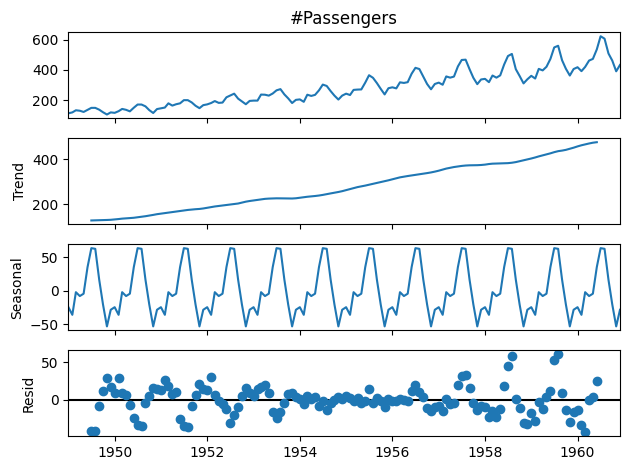

<Figure size 1200x800 with 0 Axes>

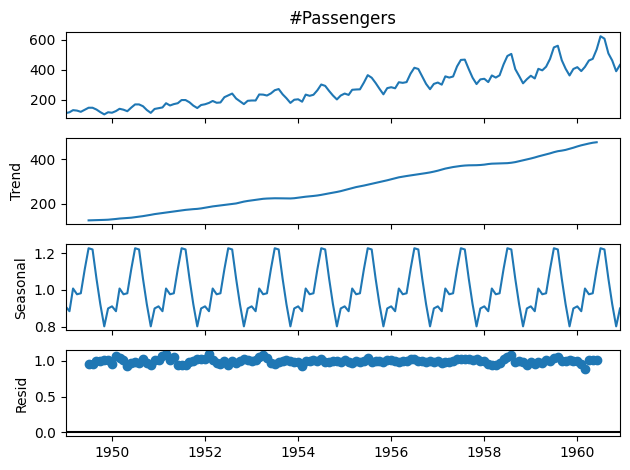

In [55]:
air_passenger['Month'] = pd.to_datetime(air_passenger['Month'])
air_passenger.set_index('Month', inplace=True)

result_add = seasonal_decompose(air_passenger['#Passengers'], model='additive', period=12)

result_mult = seasonal_decompose(air_passenger['#Passengers'], model='multiplicative', period=12)

plt.figure(figsize=(12, 8))
plt.suptitle('Additive Decomposition')
result_add.plot()
plt.show()

plt.figure(figsize=(12, 8))
plt.suptitle('Multiplicative Decomposition')
result_mult.plot()
plt.show()

In [56]:
result = seasonal_decompose(air_passenger['#Passengers'], model='multiplicative', period=12)

air_passenger['Trend'] = result.trend
air_passenger['Seasonal'] = result.seasonal
air_passenger['Residual'] = result.resid

air_passenger['Trend'] = air_passenger['Trend'].interpolate(method='linear').bfill().ffill()
air_passenger['Residual'] = air_passenger['Residual'].interpolate(method='linear').bfill().ffill()


## Explanation of Trend, Seasonal, and Residual:

### 1. Trend:
- **Description**: The trend component represents the underlying direction in which the data is moving over a longer period. It smooths out short-term fluctuations and highlights longer-term patterns.
- **Interpretation in the Dataset**: The `Trend` column shows a steady increase over time, indicating a general growth in the number of passengers from 1949 to 1960. For instance, the trend value for January 1949 is approximately 126.79, while for August 1960, it is about 475.04. This increase suggests a consistent growth in passenger numbers over the years.

### 2. Seasonal:
- **Description**: The seasonal component captures regular, repeating patterns in the data that occur at specific intervals. For monthly data, this could be seasonal variations that repeat every year.
- **Interpretation in the Dataset**: The `Seasonal` column reflects monthly seasonal effects. For instance, the value for January 1949 is approximately 0.910, indicating a lower number of passengers in January relative to the average month. Conversely, the value for August 1960 is about 1.220, suggesting a higher number of passengers in August compared to other months. This cyclical pattern repeats annually, reflecting seasonal travel trends.

### 3. Residual:
- **Description**: The residual component captures the variability in the data that cannot be explained by the trend or seasonal components. It represents the random noise and irregularities in the data.
- **Interpretation in the Dataset**: The `Residual` column shows the remaining fluctuations after removing the trend and seasonal components. For example, the residual for January 1949 is approximately 0.952, indicating a slight deviation from the expected value based on the trend and seasonality. By August 1960, the residual is about 1.012, indicating a small positive deviation. The residual values should ideally be randomly distributed around zero if the trend and seasonal components have been adequately captured.

### Summary:
- The dataset captures the monthly number of passengers along with various lagged values and moving averages to provide additional context for each observation.
- The `Trend` column shows a clear upward trend, indicating a long-term increase in the number of passengers.
- The `Seasonal` column captures the repeating monthly patterns, with some months showing consistently higher or lower passenger numbers.
- The `Residual` column captures the remaining variability that is not explained by the trend or seasonal components, representing the random noise in the data.


In [57]:
air_passenger['EMA_3'] = air_passenger['#Passengers'].ewm(span=3, adjust=False).mean()
air_passenger['EMA_6'] = air_passenger['#Passengers'].ewm(span=6, adjust=False).mean()
air_passenger['EMA_9'] = air_passenger['#Passengers'].ewm(span=9, adjust=False).mean()
air_passenger['EMA_12'] = air_passenger['#Passengers'].ewm(span=12, adjust=False).mean()


In [58]:
kf = KalmanFilter(initial_state_mean=air_passenger['#Passengers'].iloc[0], n_dim_obs=1)
state_means, _ = kf.filter(air_passenger['#Passengers'])
air_passenger['Kalman'] = state_means


In [59]:
air_passenger['rolling_std_3'] = air_passenger['#Passengers'].rolling(window=3).std()
air_passenger['rolling_std_6'] = air_passenger['#Passengers'].rolling(window=6).std()
air_passenger['rolling_std_9'] = air_passenger['#Passengers'].rolling(window=9).std()
air_passenger['rolling_std_12'] = air_passenger['#Passengers'].rolling(window=12).std()



In [60]:
air_passenger['month'] = air_passenger.index.month
air_passenger['year'] = air_passenger.index.year
air_passenger['quarter'] = air_passenger.index.quarter

In [61]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
non_na_rows = air_passenger[['lag_1', 'lag_2']].dropna().index
interaction_features = poly.fit_transform(air_passenger.loc[non_na_rows, ['lag_1', 'lag_2']])
interaction_feature_names = poly.get_feature_names_out(['lag_1', 'lag_2'])

interaction_df = pd.DataFrame(interaction_features, index=non_na_rows, columns=interaction_feature_names)
for col in interaction_df.columns:
    air_passenger.loc[non_na_rows, col] = interaction_df[col]

In [62]:
air_passenger = air_passenger.drop(columns=['1'])


In [63]:
air_passenger['fast_fourier'] = np.fft.fft(air_passenger['#Passengers']).real


In [64]:
air_passenger

,#Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,Kalman,rolling_std_3,rolling_std_6,rolling_std_9,rolling_std_12,month,year,quarter,lag_1 lag_2,fast_fourier
Month,,,,,,,,,,,,,,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112.000000,NaN,NaN,NaN,NaN,1,1949,1,NaN,40363.000000
1949-02-01,118,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,115.600000,NaN,NaN,NaN,NaN,2,1949,1,NaN,855.032345
1949-03-01,132,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,125.692308,10.263203,NaN,NaN,NaN,3,1949,1,13216.0,-48.115115
1949-04-01,129,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,...,127.735294,7.371115,NaN,NaN,NaN,4,1949,2,15576.0,517.593899
1949-05-01,121,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,...,123.573034,5.686241,NaN,NaN,NaN,5,1949,2,17028.0,-137.076762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,606,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,...,595.267962,46.306947,82.470399,87.119809,83.630500,8,1960,3,332770.0,-213.423189
1960-09-01,508,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,...,541.333395,61.719797,67.495185,82.549985,84.617276,9,1960,3,376932.0,-137.076762
1960-10-01,461,508.0,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,...,491.684627,73.979727,67.495185,78.746076,82.541954,10,1960,4,307848.0,517.593899


In [65]:
def compute_hc_adjusted(series):
    if len(series) < 100:
        return np.nan  
    return compute_Hc(series)[0]

def rolling_hurst(series, min_length, window):
    result = []
    for i in range(len(series)):
        if i < min_length - 1:
            result.append(np.nan)
        else:
            result.append(compute_hc_adjusted(series[i-window+1:i+1]))
    return pd.Series(result, index=series.index)

air_passenger['rolling_hurst_12'] = rolling_hurst(air_passenger['#Passengers'], min_length=100, window=12)


In [68]:
air_passenger = air_passenger.reset_index()

In [69]:
air_passenger['timestamp'] = air_passenger['Month']

In [70]:
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame, impute

air_passenger['Month'] = pd.to_datetime(air_passenger.index)
air_passenger['id'] = 1  
air_passenger.reset_index(drop=False, inplace=True)

df_long, y = make_forecasting_frame(air_passenger['#Passengers'], kind="passengers", max_timeshift=12, rolling_direction=1)

extracted_features = extract_features(df_long, column_id='id', column_sort='time', column_value='value')

extracted_features = impute(extracted_features)

extracted_features.reset_index(drop=True, inplace=True)

air_passenger = air_passenger.join(extracted_features)



Feature Extraction: 100%|██████████| 29/29 [00:02<00:00, 10.97it/s]
/Users/patrickpetter/Desktop/pacemaker_dev/clients/shannon_assignment/env/lib/python3.10/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__partial_autocorrelation__lag_6'
 'value__partial_autocorrelation__lag_7'
 'value__partial_autocorrelation__lag_8'
 'value__partial_autocorrelation__lag_9'
 'value__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)'
 '

In [71]:
air_passenger['Volatility_3'] = air_passenger['#Passengers'].rolling(window=3).std()
air_passenger['Volatility_6'] = air_passenger['#Passengers'].rolling(window=6).std()
air_passenger['Volatility_9'] = air_passenger['#Passengers'].rolling(window=9).std()
air_passenger['Volatility_12'] = air_passenger['#Passengers'].rolling(window=12).std()

In [72]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

air_passenger['RSI'] = calculate_rsi(air_passenger['#Passengers'])

In [74]:
air_passenger['Month']

0     1970-01-01 00:00:00.000000000
1     1970-01-01 00:00:00.000000001
2     1970-01-01 00:00:00.000000002
3     1970-01-01 00:00:00.000000003
4     1970-01-01 00:00:00.000000004
                   ...             
139   1970-01-01 00:00:00.000000139
140   1970-01-01 00:00:00.000000140
141   1970-01-01 00:00:00.000000141
142   1970-01-01 00:00:00.000000142
143   1970-01-01 00:00:00.000000143
Name: Month, Length: 144, dtype: datetime64[ns]

In [75]:
air_passenger = air_passenger.reset_index().sort_values(by='Month')

In [76]:
air_passenger.to_csv('test.csv')

In [79]:
air_passenger

,level_0,index,Month,#Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7,Volatility_3,Volatility_6,Volatility_9,Volatility_12,RSI
0,0,0,1970-01-01 00:00:00.000000000,112,NaN,NaN,NaN,NaN,NaN,NaN,...,2.079442,1.94591,1.791759,0.0,268.357143,NaN,NaN,NaN,NaN,NaN
1,1,1,1970-01-01 00:00:00.000000001,118,112.0,NaN,NaN,NaN,NaN,NaN,...,2.079442,1.94591,1.791759,0.0,268.357143,NaN,NaN,NaN,NaN,NaN
2,2,2,1970-01-01 00:00:00.000000002,132,118.0,112.0,NaN,NaN,NaN,NaN,...,2.079442,1.94591,1.791759,0.0,268.357143,10.263203,NaN,NaN,NaN,NaN
3,3,3,1970-01-01 00:00:00.000000003,129,132.0,118.0,112.0,NaN,NaN,NaN,...,2.079442,1.94591,1.791759,0.0,268.357143,7.371115,NaN,NaN,NaN,NaN
4,4,4,1970-01-01 00:00:00.000000004,121,129.0,132.0,118.0,112.0,NaN,NaN,...,-0.000000,1.94591,1.791759,0.0,268.357143,5.686241,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,139,139,1970-01-01 00:00:00.000000139,606,622.0,535.0,472.0,461.0,419.0,391.0,...,1.906155,1.94591,1.791759,0.0,511.142857,46.306947,82.470399,87.119809,83.630500,60.947712
140,140,140,1970-01-01 00:00:00.000000140,508,606.0,622.0,535.0,472.0,461.0,419.0,...,1.906155,1.94591,1.791759,0.0,517.571429,61.719797,67.495185,82.549985,84.617276,46.845426
141,141,141,1970-01-01 00:00:00.000000141,461,508.0,606.0,622.0,535.0,472.0,461.0,...,1.906155,1.94591,1.791759,0.0,523.571429,73.979727,67.495185,78.746076,82.541954,42.686567
142,142,142,1970-01-01 00:00:00.000000142,390,461.0,508.0,606.0,622.0,535.0,472.0,...,1.906155,1.94591,1.791759,0.0,523.571429,59.405387,87.805846,78.915215,79.502382,44.341085


In [80]:
air_passenger = air_passenger.drop(columns={'Month'})

# Forecast

In [83]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


target_column = '#Passengers'
timestamp_column = 'timestamp'
id_column = 'id'



ts_df = TimeSeriesDataFrame.from_data_frame(
    air_passenger,
    id_column=id_column,
    timestamp_column=timestamp_column,
)

train_df = ts_df.iloc[:-10]  
test_df = ts_df.iloc[-10:]   

predictor = TimeSeriesPredictor(
    target=target_column, 
    prediction_length=1,  
    eval_metric="MASE",
    freq='M'  
)

predictor.fit(
    train_df,
    hyperparameters={
        "DeepAR": {
            "hidden_size": 50,
            "dropout_rate": 0.2,
            "num_layers": 8,
            "epochs": 100,
            "batch_size": 64,
            "num_batches_per_epoch": 128,
            "learning_rate": 1e-4,
        },
        "DLinearModel": {
            "context_length": 96,
            "hidden_dimension": 20,
            "epochs": 100,
            "batch_size": 128,
            "num_batches_per_epoch": 100,
            "learning_rate": 1e-4,
            "weight_decay": 1e-5,
        },
        "PatchTSTModel": {
            "context_length": 192,
            "patch_len": 32,
            "stride": 16,
            "d_model": 128,
            "nhead": 16,
            "num_encoder_layers": 6,
            "epochs": 200,
            "batch_size": 128,
            "num_batches_per_epoch": 128,
            "learning_rate": 1e-4,
            "weight_decay": 1e-4,
        },
        "TemporalFusionTransformerModel": {
            "context_length": max(96, 2 * 120),
            "hidden_dim": 128,
            "variable_dim": 128,
            "num_heads": 16,
            "dropout_rate": 0.2,
            "epochs": 100,
            "batch_size": 64,
            "num_batches_per_epoch": 100,
            "learning_rate": 5e-4
        }
    },
   
)

predictions = predictor.predict(train_df)

print(predictions)


/Users/patrickpetter/Desktop/pacemaker_dev/clients/shannon_assignment/env/lib/python3.10/site-packages/autogluon/timeseries/predictor.py:199: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'M' stored as 'ME'
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240802_121226'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.6.0: Fri Jul  5 17:55:37 PDT 2024; root:xnu-10063.141.1~2/RELEASE_ARM64_T6030
CPU Count:          12
GPU Count:          0
Memory Avail:       13.31 GB / 36.00 GB (37.0%)
Disk Space Avail:   77.76 GB / 460.43 GB (16.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'ME',
 'hyperparameters': {'DLinearModel': {'batch_size': 12

                          mean        0.1      0.2         0.3         0.4  \
item_id timestamp                                                            
1       1961-01-31  287.421692 -49.446667  88.9254  169.580856  231.789139   

                           0.5         0.6         0.7        0.8         0.9  
item_id timestamp                                                              
1       1961-01-31  287.421692  343.054291  405.262543  485.91803  624.290039  


In [84]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.000002,0.015681,0.060114,4
1,DLinear,-0.000415,0.004310,12.356058,3
2,PatchTST,-0.010976,0.011371,3747.571255,2
3,DeepAR,-2.464105,0.009849,133.773620,1


In [86]:
predictions_1 = predictor.predict(train_df)


data with frequency 'MS' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [87]:
predictions_1

,,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
item_id,timestamp,,,,,,,,,,
1,1960-03-31,417.147736,399.759827,406.629364,410.831299,414.149567,417.147736,420.145874,423.464172,427.666138,434.535614
